## Задача
Компания по доставке пиццы, работа над приложением для курьеров. Есть проблема: к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены доставка очень сильно проседает в эффективности.

Data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой.

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

Сначала формулируем основные гипотезы:

Н0 - Разницы между средним временем доставки в тестовой и контрольной группе нет

Н1 - Разница между средним временем доставки в тестовой и контрольной группе есть

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

%matplotlib inline

sns.set(rc={'figure.figsize':(19, 7), 'axes.titlesize':16, 'axes.labelsize':14, 'xtick.labelsize':12, 
            'ytick.labelsize':12,'axes.titlepad': 30, # 'font.family': 'Roboto' 
           })

In [2]:
# подготовим и изучим данные
delivery = pd.read_csv('https://stepik.org/media/attachments/lesson/385916/experiment_lesson_4.csv')
delivery.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [3]:
delivery.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

Сопоставим графики распределения контрольной и тестовой групп:

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

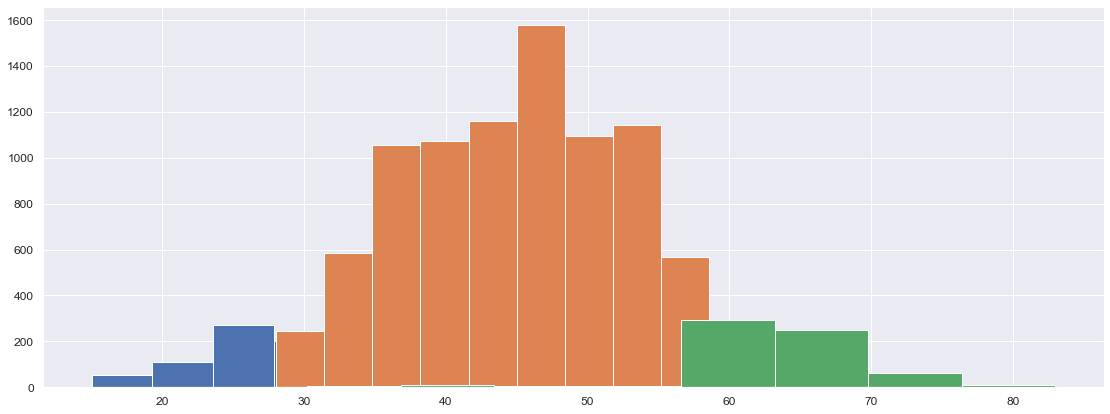

In [4]:
delivery.query('experiment_group == "control"').groupby('district').delivery_time.hist()

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

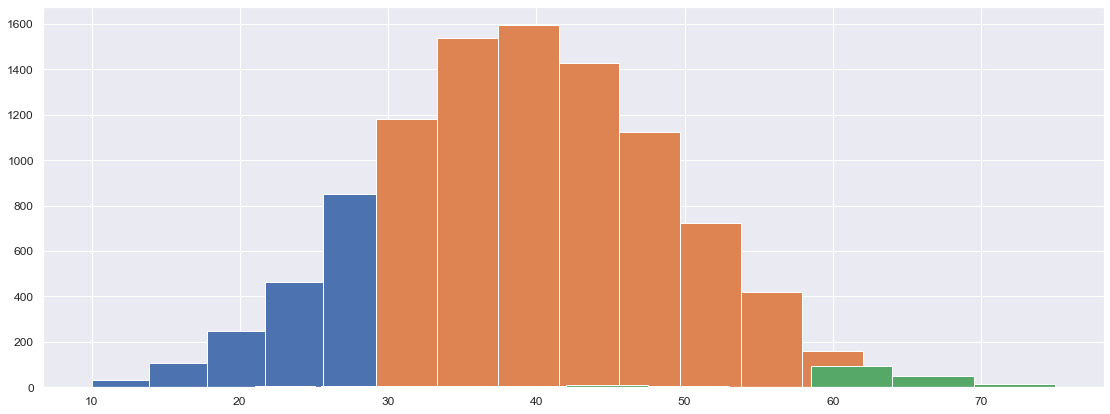

In [5]:
delivery.query('experiment_group == "test"').groupby('district').delivery_time.hist()

In [6]:
# количество наблюдений в группах
delivery.groupby('experiment_group').agg({'order_id' : 'count'})

,order_id
experiment_group,
control,10092
test,10104


Проверим распределения на нормальность с помощью теста Шапиро-Уилка и посчитаем стандартное отклонение в тесте и в контроле:

In [7]:
stats.shapiro(delivery[delivery['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17))

ShapiroResult(statistic=0.9975479245185852, pvalue=0.14013493061065674)

In [8]:
stats.shapiro(delivery[delivery['experiment_group'] == 'control']['delivery_time'].sample(1000, random_state=17))

ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)

P-value > 0.05 в обоих случаях, значит мы не можем отклонить нулевую гипотезу о нормальности распределения.

In [9]:
# стандартное отклонение в контрольной группе
np.std(delivery.query('experiment_group == "control"').delivery_time)

9.989522000652327

In [10]:
# стандартное отклонение в тестовой группе
np.std(delivery.query('experiment_group == "test"').delivery_time)

9.882819260031342

Сравним средние в тесте и контроле (с помощью t-test Стьюдента):

In [11]:
stats.ttest_ind(delivery.query('experiment_group == "control"').delivery_time, 
                delivery.query('experiment_group == "test"').delivery_time)

Ttest_indResult(statistic=43.03582663183714, pvalue=0.0)

Рассчитаем разницу среднего времени доставки в контрольной и тестовой группах:

In [12]:
mean_time_control = delivery.query('experiment_group == "control"').delivery_time.mean()

In [13]:
mean_time_test = delivery.query('experiment_group == "test"').delivery_time.mean()

In [14]:
round((mean_time_test - mean_time_control) * 100 / mean_time_control, 1)

-13.4

## Вывод:
Hаскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось.
Среднее время доставки в тесте меньше, чем в контроле на 13.4%.